# Yunding lock all-in-one notebook

## Create dataset

This section reads the `aedat4` files and creates a folder of preprocessed train and test data.
You *do not need* to run this cell if you already have the dataset ready.

In [23]:
import sys
sys.path.append("../")
%load_ext autoreload
%autoreload 2
from AER4manager import aedatconvert

conv = aedatconvert(
    data_list_file='./file_list.txt',
    accumulation_method='spikecount',
    accumulation_value=3000,
    test_fraction=0.2,
    output_resolution=(64, 64),
    crop_size=((45, 45), (2, 2)),
    hot_pixel_frequency=0.001,
).to_folder(
    out_dir='data',
    imgformat=None,  # do not save images, only .npz
    overwrite=False,
    compressed=False,  # if True smaller files, but slower to read and write
)

/home/martino/.aictx/Datasets/lock_yunding_v4/massimo_passby_00.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/yayin_toward_02.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/dylan_close_01.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/massimo_close_01.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/massimo_toward_02.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/sadique_passby_00.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/dylan_toward_02.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/martino_backward_03.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/yayin_passby_00.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/martino_toward_02.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/massimo_backward_03.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/sadique_close_01.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/dylan_passby_1_00.aedat4
/home/martino/.aictx/Datasets/lock_yunding_v4/sadique_towrad_02.aedat4
/home/martino

## Read dataset

#### Instantiate Dataset and Dataloader

In [66]:
import sys
sys.path.append("../")
from AER4manager import AERFolderDataset
import torchvision.transforms as ttr

# transforms for the training dataset
transforms = ttr.Compose([
    ttr.ToPILImage(mode='L'),
    ttr.RandomAffine(degrees=0, translate=(0, 0.2),
                     scale=(0.9, 1.1), fillcolor=0),
    ttr.RandomHorizontalFlip(),
    ttr.ToTensor()
])

transf_test = ttr.Compose([
    ttr.ToPILImage(mode='L'),
    ttr.ToTensor()
])
        
train_dataset = AERFolderDataset(
    root='data/train',
    from_spiketrain=False,
    transform=transforms,
)

test_dataset = AERFolderDataset(
    root='data/test',
    from_spiketrain=False,
    transform=transf_test
)

print("Number of training frames:", len(train_dataset))
print("Number of testing frames:", len(test_dataset))
print("Labels:", train_dataset.classes)

Number of training frames: 13048
Number of testing frames: 3320
Labels: ['0', '1']


In [67]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [68]:
train_dataset[10][0].dtype

torch.float32

#### Display examples

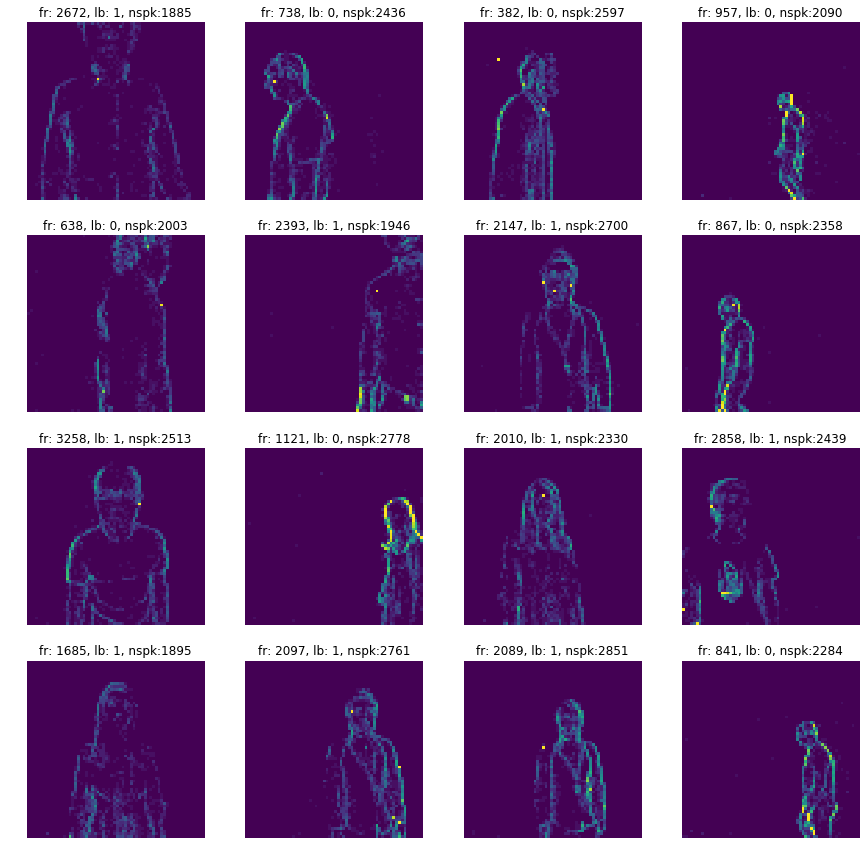

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.figure(figsize=(15, 15))
for i, idx in enumerate(np.random.choice(len(test_dataset), size=16)):
    image, label = test_dataset[idx]
    plt.subplot(4, 4, i+1)
    nspk = int(image.sum()*255)
    plt.title(f"fr: {idx}, lb: {label}, nspk:{nspk}")
    plt.imshow(image[0], vmin=0, vmax=0.1)
    plt.axis("off")
    if i==15: break

## Define the model

In [75]:
from torch.functional import F
import torch

class MyClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels= 8, kernel_size=(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)),
            torch.nn.Conv2d(in_channels=8, out_channels= 12, kernel_size=(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)),
            torch.nn.Conv2d(in_channels=12, out_channels= 12, kernel_size=(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)),
            torch.nn.Dropout2d(0.5),
            torch.nn.Flatten(),
            torch.nn.Linear(432, 128, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2, bias=False),
            torch.nn.ReLU(),
        )
        
    def forward(self, x):
        return self.seq(x)

In [76]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define model and learning parameters
myclass = MyClassifier().to(device)
# Define loss
criterion = torch.nn.CrossEntropyLoss()
# Define optimizer
optimizer = torch.optim.Adam(myclass.parameters(), lr = 1e-3)

# Impose Kaiming He initialization
for w in myclass.parameters():
    torch.nn.init.kaiming_uniform_(w, nonlinearity='relu')

In [90]:
from tqdm import tqdm_notebook as tqdm
from torch import nn

n_epochs = 80
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    accuracy_train = []
    # Set to training mode
    myclass.train()
    running_loss = 0
    
    for batch_id, sample in enumerate(train_dataloader):
        imgs, labels = sample
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = myclass(imgs.to(device))

        _, predicted = torch.max(outputs, 1)
        binary_labels = labels # torch.max(labels, 1)
        acc = (predicted == binary_labels.to(device)).sum().float()/len(labels)
        accuracy_train.append(acc.cpu().numpy())

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    # Test network accuracy
    with torch.no_grad():
        # Set to eval mode
        myclass.eval()
        
        accuracy = []
        for batch_id, sample in enumerate(test_dataloader):
            test_data, test_labels = sample
            outputs = myclass(test_data.to(device))
                        
            _, predicted = torch.max(outputs, 1)
            test_bin_labels = test_labels # torch.max(test_labels, 1)
            
            acc =(predicted==test_bin_labels.to(device)).sum().float()/len(test_labels)
            accuracy.append(acc.cpu().numpy())
        accuracy = np.mean(accuracy)
    accuracy_train = np.mean(accuracy_train)
        
    pbar.set_postfix(loss=running_loss, epoch=epoch, accuracy_test=accuracy, accuracy_train=accuracy_train)
        
        

In [36]:
# Save trained model        
model_name = 'torch_model_yunding_shuffled_closeby'
torch.save(myclass.state_dict(), strOutDir+model_name+'.pt')
print("Model saved")

Model saved


In [37]:
trained_dir = '../../demo/live_yunding/trained_models/'

weight_dict = torch.load(strOutDir+model_name+'.pt')

weights = [w.cpu().detach().numpy().copy() for w in weight_dict.values()]
[np.mean(w) for w in weights]

[-0.024215592, 0.004262977, 0.042150095, -0.028125683, 0.04709022]

In [4]:
from AERUtils.estimate.modelestimate import ModelEstimate
from sinabs import Network
from sinabs.from_torch import from_model

net = Network()
net.analog_model = MyClassifier()
net.spiking_model = from_model(net.analog_model, (1, 64, 64))

weightRescaleFactor = {"conv1": 1, 'conv2': 1, 'conv2': 1, 'linear1': 1, 'linear2': 1}
model_estimate = ModelEstimate(
    from_keras=False,
    torch_device='cuda:0',
    snn_network=net
)


model_estimate.set_weights(weights)
model_estimate.to(model_estimate.torch_device)

# Move to device

model_estimate.rescale_parameters(weight_rescaling=weightRescaleFactor)

(8, 62, 62)
(8, 31, 31)
(12, 29, 29)
(12, 14, 14)
(12, 12, 12)
(12, 6, 6)
(432,)
(128,)
(2,)
cuda:0


/home/martino/Work/sinabs/sinabs/from_torch.py:267: UserWarning: Layer 'Dropout2d' is not supported. Skipping!
  warn(f"Layer '{type(module).__name__}' is not supported. Skipping!")


NameError: name 'weights' is not defined

In [15]:
sum([np.prod(t.size()) for t in net.analog_model.parameters()]) # same as keras notebook?

57784

In [42]:
model_estimate.accuracy_spiking_dataset(dataset_manager=datasetManager, synops=True, spike_align=False, test_num=0)

  0%|          | 0/1440 [00:00<?, ?it/s]


AttributeError: 'Dropout2d' object has no attribute 'spikes_number'

In [43]:
model_estimate.accuracy_analog_dataset(dataset_manager=datasetManager)

100%|██████████| 1440/1440 [00:01<00:00, 794.95it/s]

Prediction accuracy of the analog model is: 91.67


91.66666666666666